**Run the demo.** Run the following cells to synthesize example image pairs from a prompt of your choice and our predicted semantic correspondences.

In [1]:
%load_ext autoreload
%autoreload 2
from archs.stable_diffusion.diffusion import latent_to_image
from archs.stable_diffusion.resnet import collect_dims
from archs.correspondence_utils import (
  batch_cosine_sim,
  rescale_points,
  find_nn_correspondences,
  draw_correspondences,
  points_to_patches,
  compute_pck
)
import os
import random
import torch
import math
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import pandas as pd

from extract_hyperfeatures import load_models

**Initialize DiffusionExtractor and AggregationNetwork.**

In [2]:
# Memory requirement is 13731MiB
device = "cuda"
config_path = "configs/synthetic.yaml"
config, diffusion_extractor, aggregation_network = load_models(config_path, device)

assert "one-step" not in config["weights_path"], "One-Step model not supported in the synthetic demo"

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/home/g-luo/miniconda3/envs/diffusion_hyperfeatures/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


diffusion_mode: generation
idxs: [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2)]
output_resolution: 64
prompt: 
negative_prompt: poorly drawn, ugly, tiling, out of frame, mutation, mutated, extra limbs, extra legs, extra arms, disfigured, deformed, cross-eye, body out of frame, blurry, bad art, bad anatomy, blurred, text, watermark, grainy,  writing, calligraphy, sign, cut off


**Synthesize an image pair given the text prompt.**

In [3]:
guidance_scale = 7.5
prompt = "A raccoon playing chess with oversized pieces."
negative_prompt = config["negative_prompt"]

In [4]:
diffusion_extractor.change_cond(prompt, "cond")
diffusion_extractor.change_cond(negative_prompt, "uncond")

latents = torch.randn((diffusion_extractor.batch_size, diffusion_extractor.unet.in_channels, 512 // 8, 512 // 8), device=diffusion_extractor.device, generator=diffusion_extractor.generator)
hash_name = str(random.getrandbits(32))

print("Guidance Scale:", guidance_scale)
print("Prompt:", diffusion_extractor.prompt)
print("Negative Prompt:", diffusion_extractor.negative_prompt)

Guidance Scale: 7.5
Prompt: A raccoon playing chess with oversized pieces.
Negative Prompt: poorly drawn, ugly, tiling, out of frame, mutation, mutated, extra limbs, extra legs, extra arms, disfigured, deformed, cross-eye, body out of frame, blurry, bad art, bad anatomy, blurred, text, watermark, grainy,  writing, calligraphy, sign, cut off


/home/g-luo/miniconda3/envs/diffusion_hyperfeatures/lib/python3.8/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/home/g-luo/remote_home/diffusion_hyperfeatures/archs/aggregation_network.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  mixing_weights = torch.nn.functional.softmax(self.mixing_weights)


<Figure size 640x480 with 0 Axes>

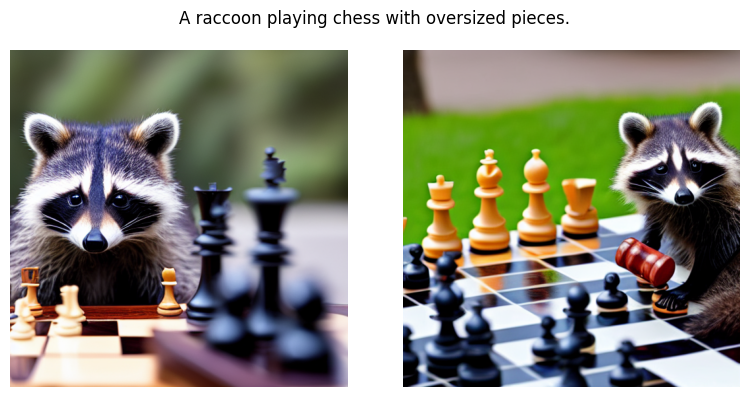

In [5]:
%matplotlib inline
with torch.inference_mode():
  feats, outputs = diffusion_extractor.forward(latents=latents, guidance_scale=guidance_scale)
  if feats is not None:
    """
    feats is the cached feature maps of shape (B, S, L, W, H) where
    B is the batch size
    S is the length of save_timestep
    L is the length of dims / the number of layers
    W, H is the dimension of the latent

    outputs is the x0 predictions (not xt) of length num_timesteps + 1 where
    the first element is the starting noise and the last is the final image
    """
    # reverse feats along the time dimension S
    # when passing to the aggregation network since it was trained
    # on feature maps from the inversion process (image to noise)
    # and we are running the generation process (noise to image)
    b, s, l, w, h = feats.shape
    diffusion_hyperfeats = aggregation_network(torch.flip(feats, dims=(1,)).float().view(b, -1, w, h))
synthetic_images = diffusion_extractor.latents_to_images(outputs[-1])

plt.clf()
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(synthetic_images[0])
axs[0].axis("off")
axs[1].imshow(synthetic_images[1])
axs[1].axis("off")
fig.suptitle(prompt)
fig.tight_layout()
plt.show()

**Interactively annotate semantic keypoint matches.**
- Setting 1: Set `show_dhf=False` and manually annotate the ground truth correspondences. Select a point on the left image then the semantically corresponding point on the right image. Repeat this for multiple point pairs. Re-run the cell to re-do the annotations. Finally, compare your annotations with the predicted semantic correspondences from Diffusion Hyperfeatures in the next section.
- Setting 2: Set `show_dhf=True` and click on the left image to immediately view the predicted semantic correspondences from Diffusion Hyperfeatures in the right image. 

In [6]:
# To interactively see what Diffusion Hyperfeatures predicts
# as the corresponding keypoint, simply set this flag to true
# and the prediction will appear as a green point on the right image.
# Your annotations will show up as red points in both images.
show_dhf = False

In [7]:
def get_corresponding_points(img1_feats, img2_feats, output_size, load_size):
  """
  Precompute nearest neighbor for every pixel in img1.
  To reduce memory usage, we do this computation in
  with descriptor maps of shape output_size and rescale to the load_size.
  """
  sims = batch_cosine_sim(img1_feats[None, ...], img2_feats[None, ...])
  num_pixels = int(math.sqrt(sims.shape[-1]))
  points1, points2 = find_nn_correspondences(sims)
  points1, points2 = points1[0].detach().cpu().numpy(), points2[0].detach().cpu().numpy()
  points1 = rescale_points(points1, output_size, load_size)
  points2 = rescale_points(points2, output_size, load_size)
  return points1, points2

# Set the load_size to 224 so that the PCK metric is comparable to prior work
# To view the predictions in full resolution, change load_size to (512, 512)
i, j = 0, 1
output_size = (config["output_resolution"], config["output_resolution"])
load_size = (224, 224)
img1, img2 = synthetic_images[i].resize(load_size), synthetic_images[j].resize(load_size)
points1_dhf, points2_dhf = get_corresponding_points(
  diffusion_hyperfeats[i],
  diffusion_hyperfeats[j],
  output_size,
  load_size
)

/home/g-luo/miniconda3/envs/diffusion_hyperfeatures/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811806235/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/g-luo/remote_home/diffusion_hyperfeatures/archs/correspondence_utils.py:101: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  points2_y = points2 // h


15

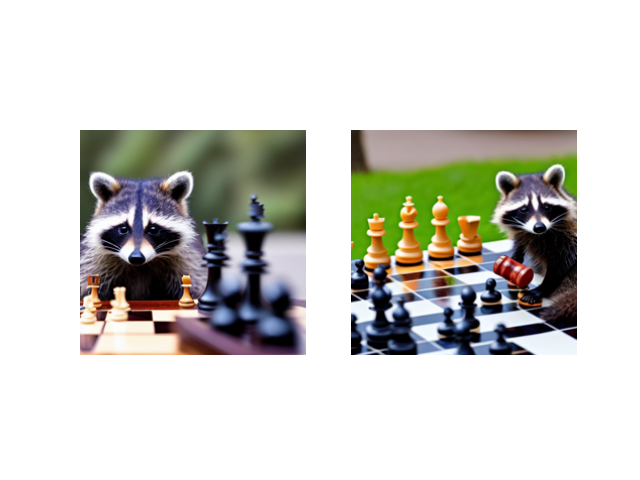

In [8]:
%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np

user_source_points, user_target_points = [], []
dhf_points = []

fig, axes = plt.subplots(1, 2)
axes[0].imshow(img1)
axes[0].axis("off")
axes[1].imshow(img2)
axes[1].axis("off")
plt.draw()

def mouse_event(event):
  radius1, radius2 = 8, 1
  y, x = event.ydata, event.xdata
  
  if event.inaxes == axes[0]:
    color = "r"
    circ1_1 = plt.Circle((x, y), radius1, facecolor=color, edgecolor='white', alpha=0.5)
    circ1_2 = plt.Circle((x, y), radius2, facecolor=color, edgecolor='white')
    axes[0].add_patch(circ1_1)
    axes[0].add_patch(circ1_2)
    user_source_points.append((y, x))

    y_patch, x_patch = points_to_patches(np.array([[y, x]]), output_size[0], load_size)[0]
    idx = int(y_patch * output_size[0] + x_patch)

    # Diffusion Hyperfeatures
    y2, x2 = points2_dhf[idx]
    dhf_points.append((y2, x2))
    if show_dhf:
      color = "g"
      circ1_1 = plt.Circle((x2, y2), radius1, facecolor=color, edgecolor='white', alpha=0.5)
      circ1_2 = plt.Circle((x2, y2), radius2, facecolor=color, edgecolor='white')
      axes[1].add_patch(circ1_1)
      axes[1].add_patch(circ1_2)

  if event.inaxes == axes[1]:
    color = "r"
    circ1_1 = plt.Circle((x, y), radius1, facecolor=color, edgecolor='white', alpha=0.5)
    circ1_2 = plt.Circle((x, y), radius2, facecolor=color, edgecolor='white')
    axes[1].add_patch(circ1_1)
    axes[1].add_patch(circ1_2)
    user_target_points.append((y, x))

  fig.canvas.draw()

fig.canvas.mpl_connect('button_press_event', mouse_event)

**Display results.** Do not run this section if you are not running Setting 1, as it needs ground-truth annotations to compute the PCK for the predicted correspondences from Diffusion Hyperfeatures.

In [11]:
def log_predicted_points(title, prefix, predicted_points, user_source_points, user_target_points, load_size, img1, img2, df):
  distances, _, pck_metric = compute_pck(predicted_points, user_target_points, load_size)
  title = f"{title} \n PCK@0.1: {pck_metric.round(decimals=2)}"
  plt.clf()
  draw_correspondences(user_source_points, predicted_points, img1, img2, "", "", title=title, radius1=8, radius2=1)
  plt.show()
  df.update({
    f"{prefix}_points_y": predicted_points[:, 0],
    f"{prefix}_points_x": predicted_points[:, 1],
    f"{prefix}_distances": distances
  })
  return df

<Figure size 640x480 with 0 Axes>

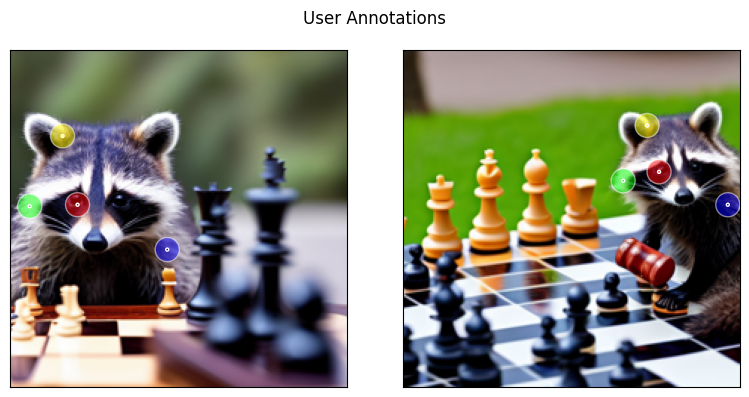

<Figure size 640x480 with 0 Axes>

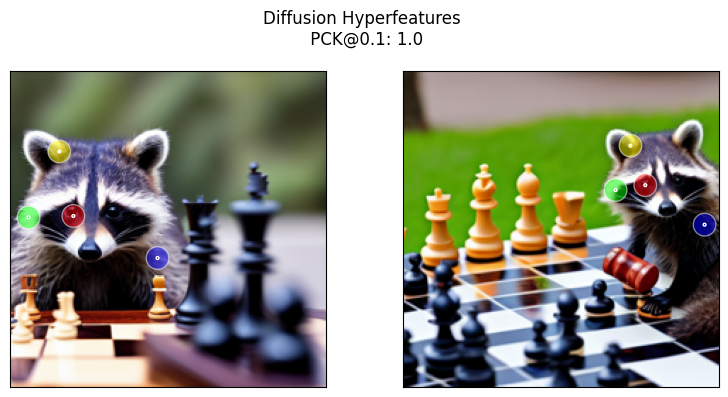

In [12]:
%matplotlib inline
if len(user_target_points) > 0 and len(user_source_points) == len(user_target_points):
  user_source_points, user_target_points = np.array(user_source_points), np.array(user_target_points)
  dhf_points = np.array(dhf_points)
  df = {
    "hash_name": [hash_name] * len(user_source_points),
    "user_source_points_y": user_source_points[:, 0],
    "user_source_points_x": user_source_points[:, 1],
    "user_target_points_y": user_target_points[:, 0],
    "user_target_points_x": user_target_points[:, 1]
  }

  # Log correspondence plots
  plt.clf()
  title = "User Annotations"
  draw_correspondences(user_source_points, user_target_points, img1, img2, "", "", title=title, radius1=8, radius2=1)
  plt.show()
  df = log_predicted_points("Diffusion Hyperfeatures", "dhf", dhf_points, user_source_points, user_target_points, load_size, img1, img2, df)

,hash_name,user_source_points_y,user_source_points_x,user_target_points_y,user_target_points_x,dhf_points_y,dhf_points_x,dhf_distances
0,1192081269,102.344995,44.390798,80.486930,170.029508,80.5,171.5,1.470550
1,1192081269,56.641769,34.455314,49.686930,162.081121,52.5,161.0,3.013666
2,1192081269,132.151447,104.003701,102.344995,215.732734,108.5,213.5,6.547456
3,1192081269,103.338543,12.597250,86.448221,146.184346,84.0,150.5,4.961718


<Figure size 640x480 with 0 Axes>

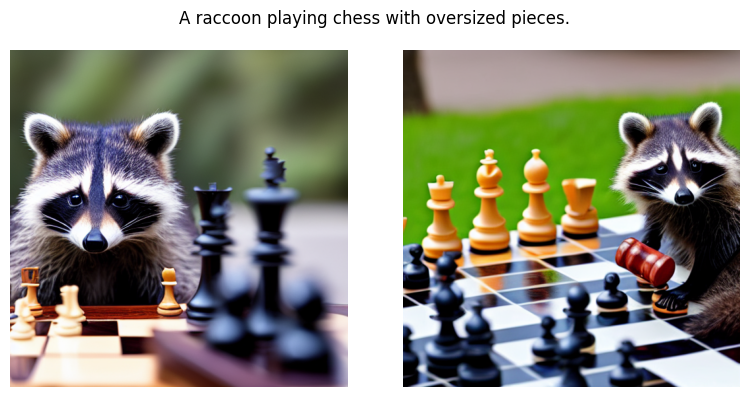

In [13]:
if len(user_target_points) > 0 and len(user_source_points) == len(user_target_points):
  # Log PCK distances
  df = pd.DataFrame(df)
  display(df)

  # Log images
  plt.clf()
  fig, axs = plt.subplots(1, 2, figsize=(8, 4))
  axs[0].imshow(synthetic_images[0])
  axs[0].axis("off")
  axs[1].imshow(synthetic_images[1])
  axs[1].axis("off")
  fig.suptitle(prompt)
  fig.tight_layout()
  plt.show()

  # Save the noise used for this run
  if not os.path.exists("seeds"):
    os.mkdir("seeds")
  seeds = outputs[0]
  torch.save(seeds, f"seeds/{hash_name}.pt")